# Using python and machine learning to predict energy consumption

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
sns.set()

# Part 1

## Importing data

In [3]:
filepath = "/home/jvictor/vs_code/time_series_forecasting_with_xgboost/energy_consumption/data/PJME_hourly.csv"
df = pd.read_csv(filepath)

In [4]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [6]:
df.Datetime = pd.to_datetime(df["Datetime"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [8]:
df.set_index("Datetime", inplace=True)

In [9]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


## Visualizing data

<AxesSubplot:title={'center':'PJME Energy Use in MW'}, xlabel='Datetime'>

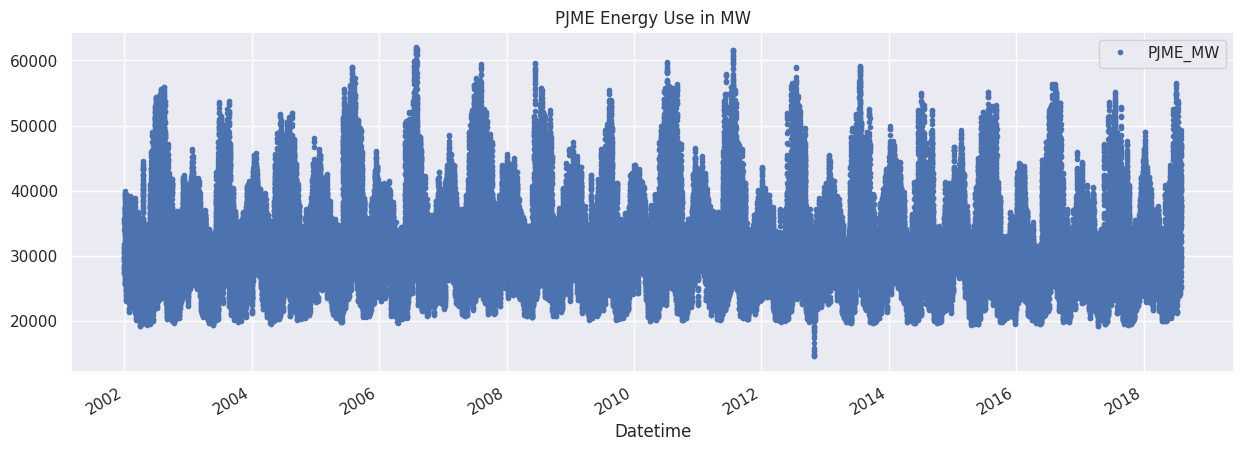

In [10]:
df.plot(style=".", figsize=(15,5), title="PJME Energy Use in MW")

## Data preparation: Train / Test split

In [11]:
split_date_point = '01-01-2015'
data_filter_less = df.index < split_date_point
data_filter_geq = df.index >= split_date_point

train = df.loc[data_filter_less]
test = df.loc[data_filter_geq]

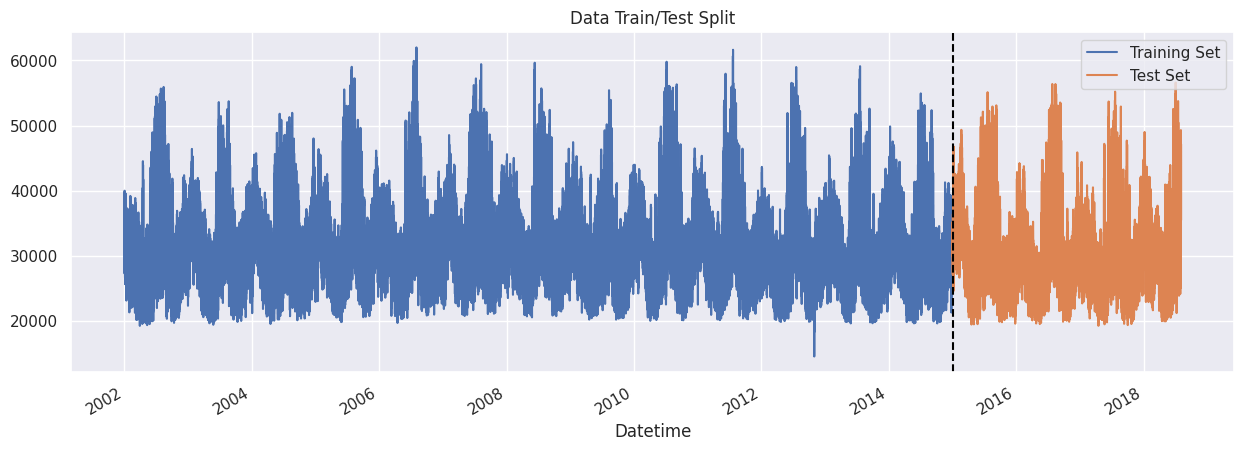

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")
ax.axvline(split_date_point, color="black", ls="--")
ax.legend(["Training Set", "Test Set"])

## Visualizing data of one week

<AxesSubplot:xlabel='Datetime'>

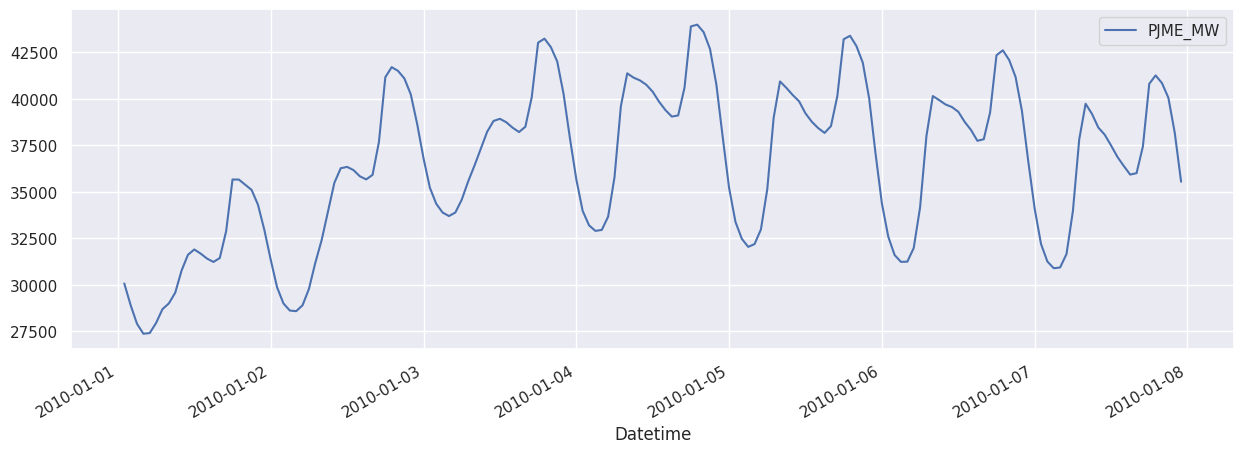

In [13]:
one_week_of_data_filter = (df.index > '01-01-2010') & (df.index < '01-08-2010')
df.loc[one_week_of_data_filter].plot(figsize=(15,5))

## Feature Creation

In [14]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index 
    and adds these new features to a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame that we want to add new features.

    Returns:
        pd.DataFrame: An updated DataFrame with new features.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    
    return df

In [15]:
df = create_features(df=df)

## Visualize our Feature / Target Relantionship

Text(0.5, 1.0, 'MW by hour')

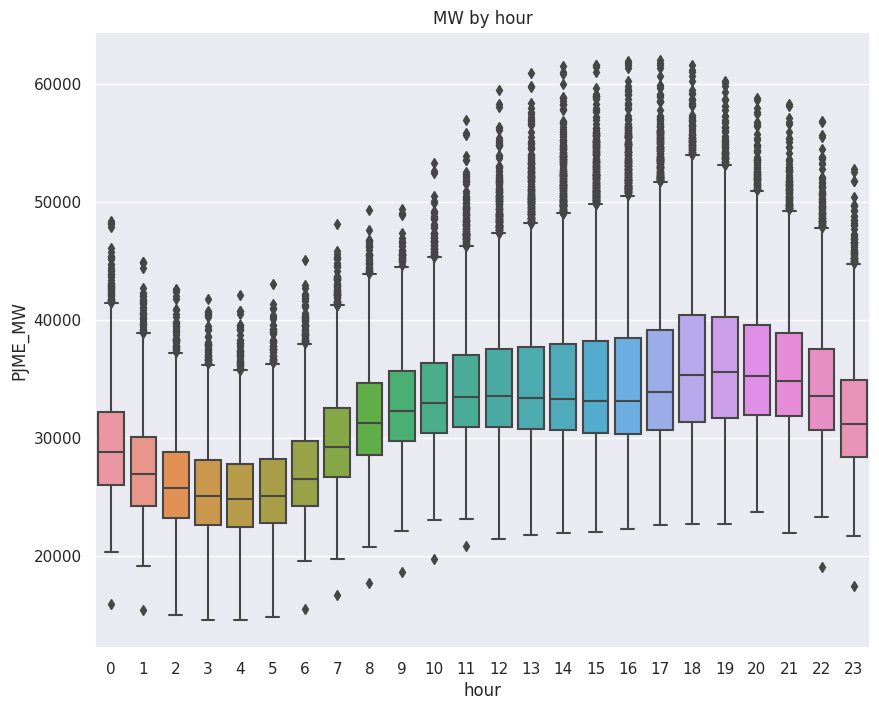

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x="hour", y="PJME_MW")
ax.set_title("MW by hour")

Text(0.5, 1.0, 'MW by month')

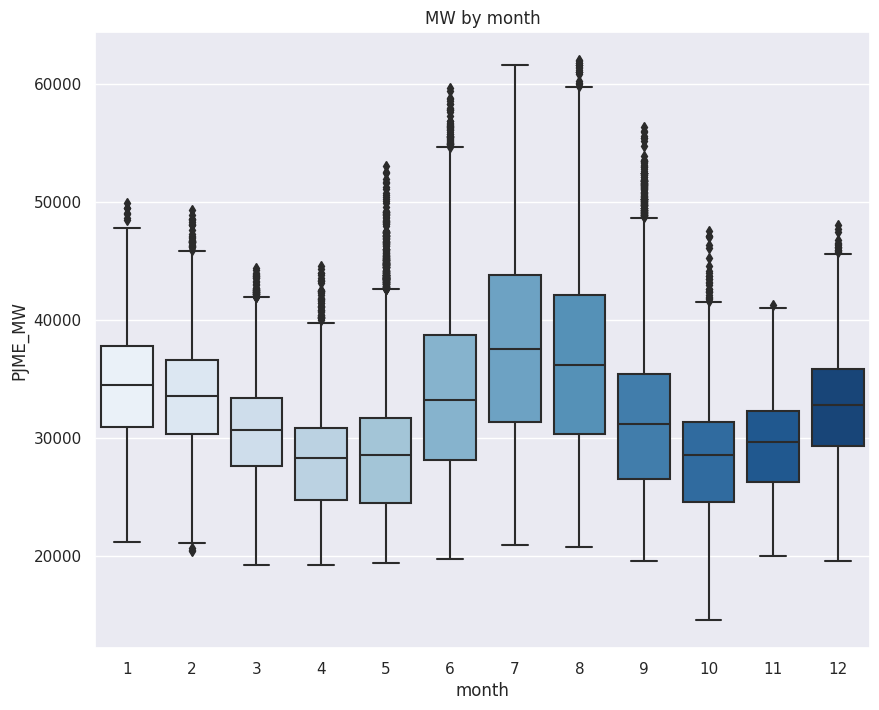

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x="month", y="PJME_MW", palette="Blues")
ax.set_title("MW by month")

## Creating the model

In [18]:
train = create_features(train)
test = create_features(test)

In [19]:
FEATURES = [column for column in df.columns if column != "PJME_MW"]
TARGET = df.columns[0]

In [20]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [21]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[437]	validation_0-rmse:2793.31200	validation_1-rmse:3727.16078


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

## Feature Importance

In [22]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"])

In [23]:
fi

,importance
hour,0.448121
dayofweek,0.159098
quarter,0.029913
month,0.230090
year,0.022350
dayofyear,0.110429


<AxesSubplot:title={'center':'Feature Importance'}>

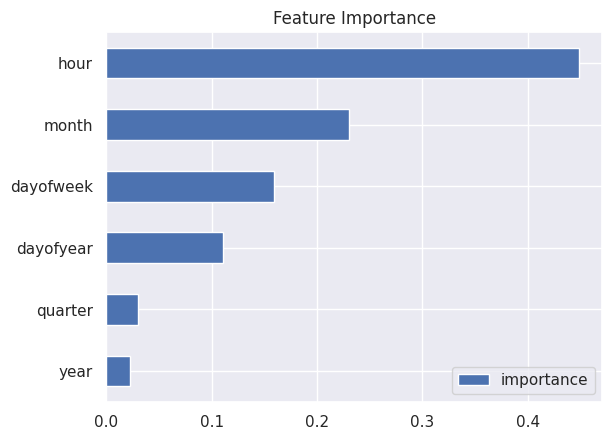

In [24]:
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")

## Forecast on test

In [25]:
test["prediction"] = reg.predict(X_test)

In [26]:
df = df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)

Text(0.5, 1.0, 'Raw Data and Prediction')

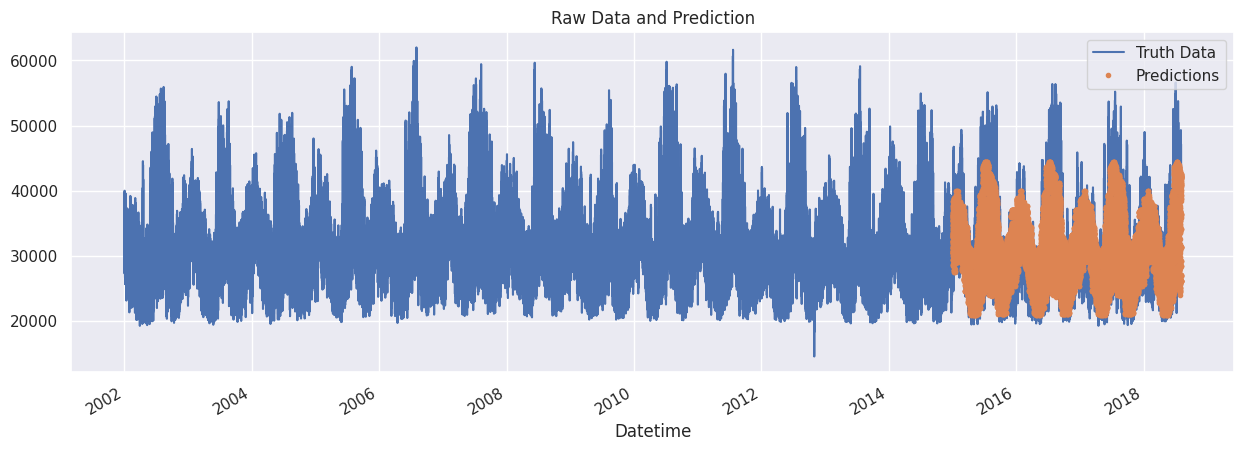

In [27]:
ax = df[["PJME_MW"]].plot(figsize=(15,5))
df["prediction"].plot(ax=ax, style=".")
ax.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Data and Prediction")

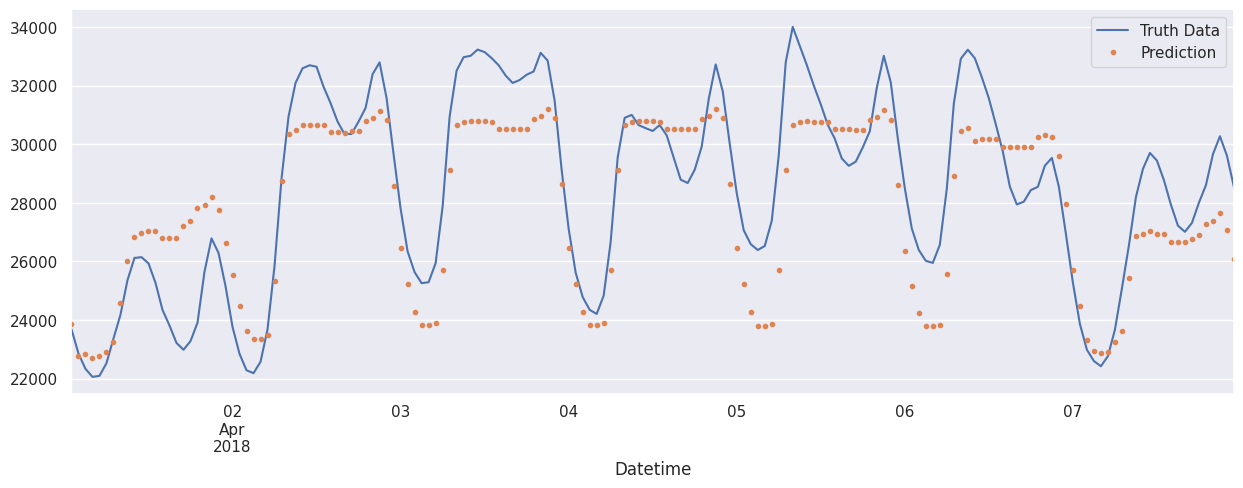

In [28]:
one_week_of_data_filter = (df.index > '04-01-2018') & (df.index < '04-08-2018')
ax = df.loc[one_week_of_data_filter]["PJME_MW"].plot(figsize=(15,5))
df.loc[one_week_of_data_filter]["prediction"].plot(style=".")
ax.legend(["Truth Data", "Prediction"])

## Calculate Error

In [29]:
mean_squared_error(test["PJME_MW"], test["prediction"])

13797734.544390151

In [30]:
score = np.sqrt(mean_squared_error(test["PJME_MW"], test["prediction"]))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 3714.53


In [31]:
test["error"] = np.abs(test[TARGET] - test["prediction"])

* Look at the worst and best predicted days

In [32]:
test["date"] = test.index.date

In [33]:
test.groupby("date")["error"].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14559.813965
2016-08-14    14393.350911
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
Name: error, dtype: float64

In [34]:
test.groupby("date")["error"].mean().sort_values(ascending=True).head(5)

date
2016-09-27    376.074544
2016-05-01    420.460286
2016-04-04    432.775065
2015-03-10    444.994792
2016-12-08    480.121663
Name: error, dtype: float64

# Part 2

* Outlier analysis
* Forecasting horizon explained
* Time series cross validation
* Lag Features
* Predicting the Future

## Outlier analysis and removal

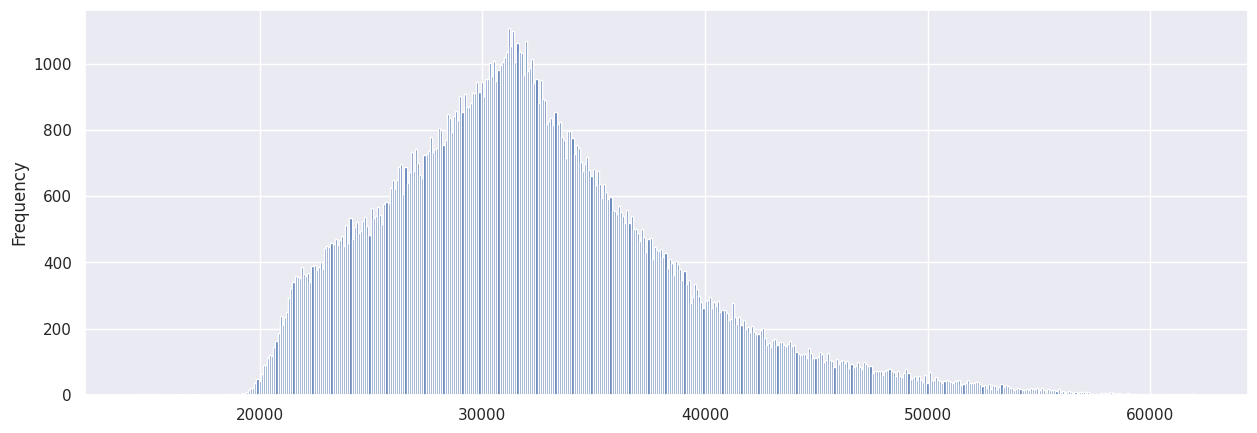

In [55]:
df2 = pd.read_csv(filepath)
df2.Datetime = pd.to_datetime(df2.Datetime)
df2.set_index("Datetime", inplace=True)
fig, ax = plt.subplots(figsize=(15,5))
ax = df2["PJME_MW"].plot(kind="hist", bins=500)

<AxesSubplot:xlabel='Datetime'>

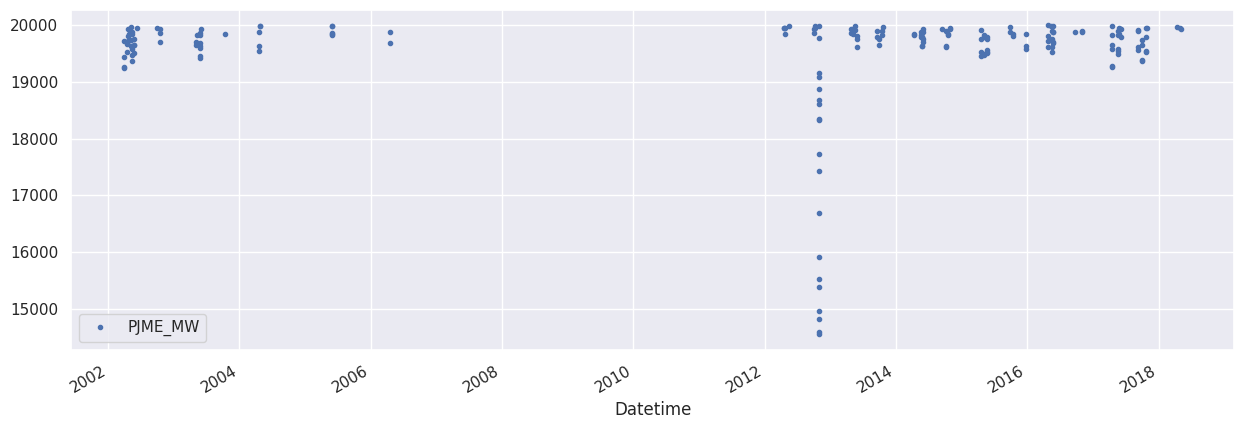

In [56]:
df2.query('PJME_MW < 20_000').plot(figsize=(15,5), style=".")

<AxesSubplot:xlabel='Datetime'>

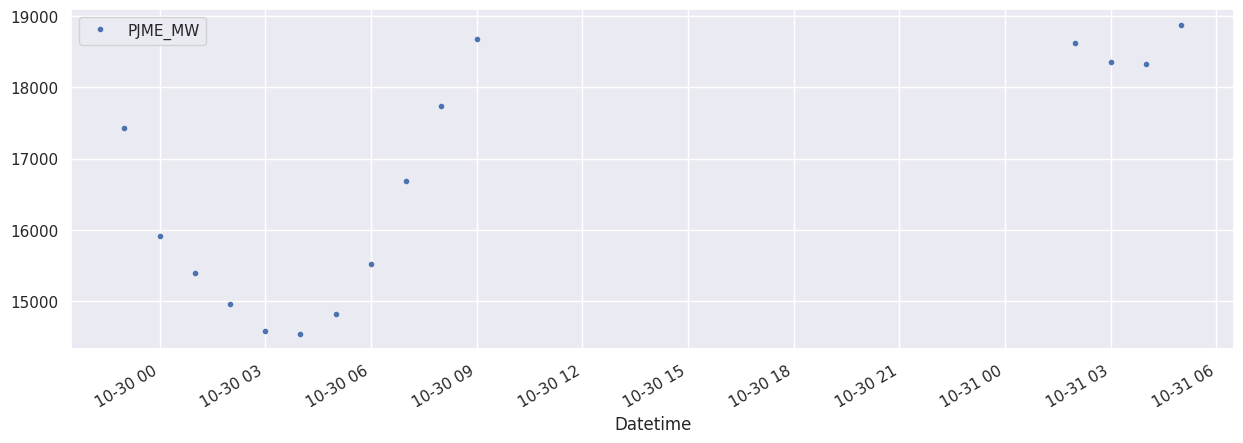

In [57]:
df2.query('PJME_MW < 19_000').plot(figsize=(15,5), style=".")

In [58]:
df3 = df2[df2["PJME_MW"] > 19000].copy()

In [59]:
split_date_point = '01-01-2015'
data_filter_less = df3.index < split_date_point
data_filter_geq = df3.index >= split_date_point

train = df3.loc[data_filter_less]
test = df3.loc[data_filter_geq]

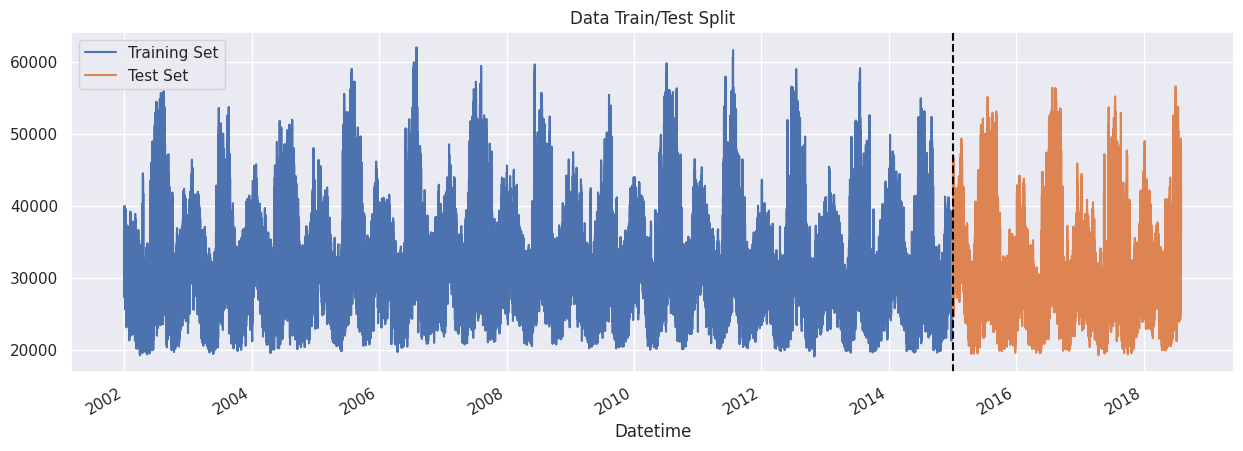

In [60]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")
ax.axvline(split_date_point, color="black", ls="--")
ax.legend(["Training Set", "Test Set"])

## Time Series Cross Validation

In [61]:
test_size = 24*365*1
tss = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=24)
df3 = df3.sort_index()

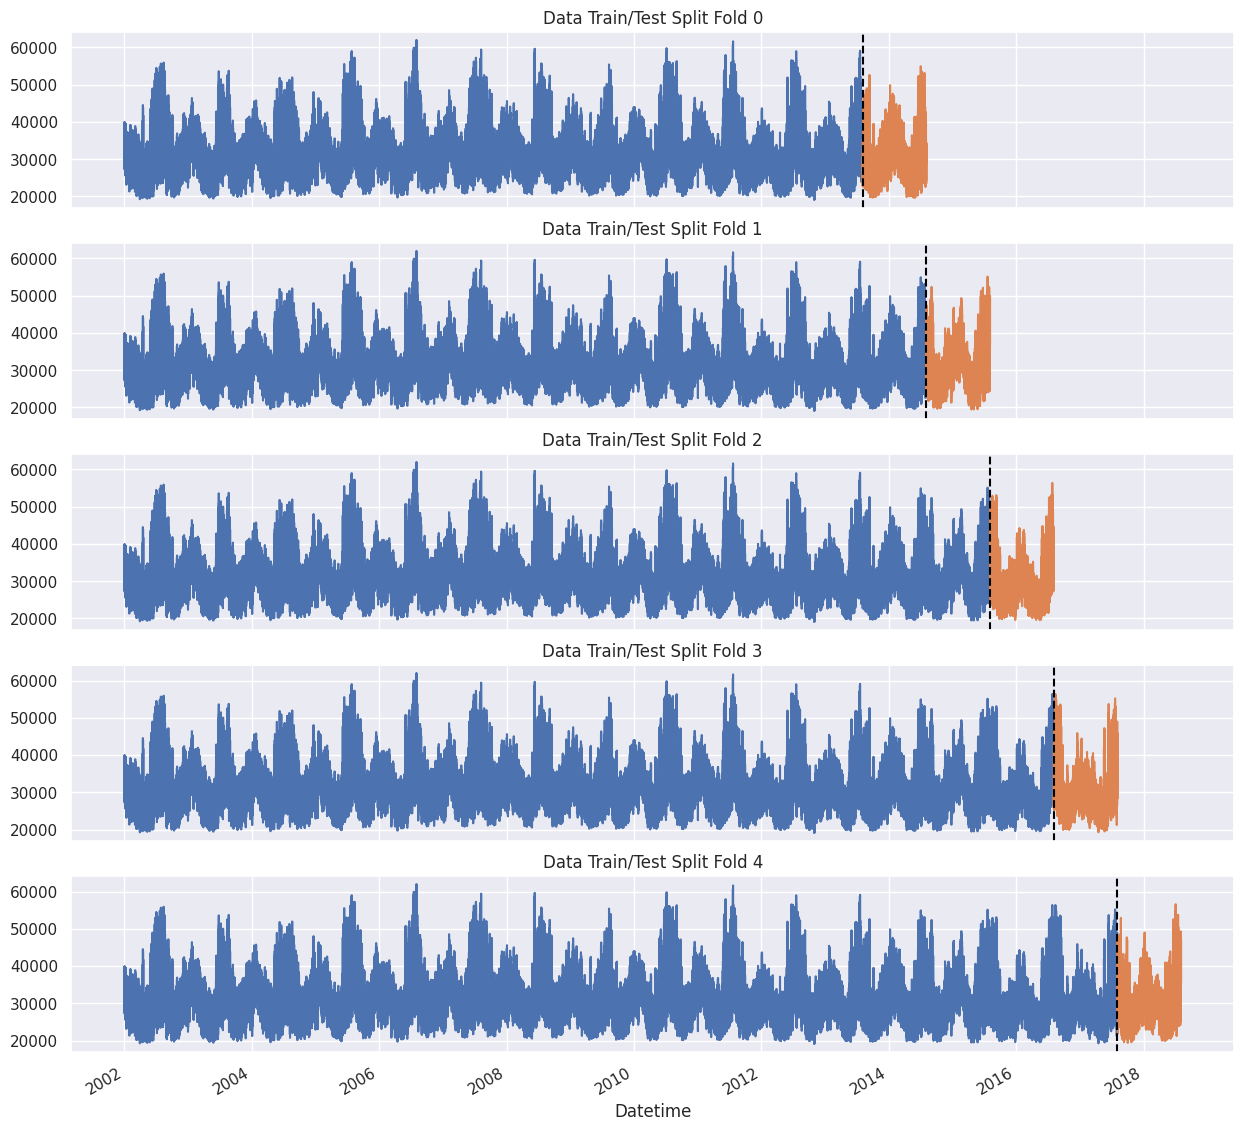

In [62]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df3):
    train = df3.iloc[train_idx]
    test = df3.iloc[val_idx]
    train["PJME_MW"].plot(ax=axs[fold], label="Training Set", title=f"Data Train/Test Split Fold {fold}")
    test["PJME_MW"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1

## Forecasting Horizon Explained

The forecast horizon is the length of time into the future for which forecasts are to be preapared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [65]:
def create_features_v2(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index 
    and adds these new features to a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame that we want to add new features.

    Returns:
        pd.DataFrame: An updated DataFrame with new features.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    df["weekofyear"] = df["weekofyear"].astype(int)
    
    return df

In [66]:
df3 = create_features_v2(df=df3)

## Lag Features

* What was the target (x) days in the past.

In [68]:
target_map = df3["PJME_MW"].to_dict()

In [69]:
def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    
    target_map = df["PJME_MW"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    
    return df

In [70]:
df3 = add_lags(df=df3)

In [71]:
df3.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN


In [72]:
df3.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


## Train Using Cross Validation

In [73]:
tss = TimeSeriesSplit(n_splits=5, test_size=test_size, gap=24)
df3 = df3.sort_index()

fold = 0
preds = []
scores = []

FEATURES = [column for column in df3.columns if column != "PJME_MW"]
TARGET = df3.columns[0]

for train_idx, val_idx in tss.split(df3):
    
    train = df3.iloc[train_idx]
    test = df3.iloc[val_idx]
    
    train = create_features_v2(train)
    test = create_features_v2(test)
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster="gbtree", 
                           n_estimators=1000, early_stopping_rounds=50,
                           objective="reg:linear", max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100) 
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    

[20:36:30] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.09981	validation_1-rmse:11906.29619
[200]	validation_0-rmse:5744.61853	validation_1-rmse:5353.78695
[300]	validation_0-rmse:3869.36280	validation_1-rmse:3895.34580
[400]	validation_0-rmse:3432.34635	validation_1-rmse:3758.98584
[457]	validation_0-rmse:3349.18382	validation_1-rmse:3762.91006
[20:36:42] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.57784	validation_1-rmse:12221.41614
[200]	validation_0-rmse:5754.45665	validation_1-rmse:5660.52662
[300]	validation_0-rmse:3904.48736	validation_1-rmse:3936.47111
[400]	validation_0-rmse:3476.67763	validation_1-rmse:3596.44943
[500]	validation_0-rmse:3353.98759	validation_1-rmse:3

In [74]:
scores

[3758.10747111328,
 3437.5933472202546,
 3471.0915419351513,
 4085.110321120483,
 3999.9151075187165]

## Predicting the future

* Retraining on all data
* To predict the future we need an empty dataframe for future date ranges
* Run those dates through our features creation + lag creation

In [75]:
df4 = df2.copy()

In [78]:
df4 = create_features(df=df4)

FEATURES = [column for column in df4.columns if column != "PJME_MW"]
TARGET = df4.columns[0]

X_all = df4[FEATURES]
y_all = df4[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster="gbtree",
                       n_estimators=500,
                       objective="reg:linear",
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[21:07:31] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32404.79158
[100]	validation_0-rmse:12535.02525
[200]	validation_0-rmse:5875.37651
[300]	validation_0-rmse:4006.54231
[400]	validation_0-rmse:3543.87594
[499]	validation_0-rmse:3393.90298


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [84]:
# Create future DataFrame
future = pd.date_range(start="2018-08-03", end="2019-08-01", freq="1h")
df_future = pd.DataFrame(index=future)
df_future["isFuture"] = True
df4["isFuture"] = False
df4_and_future = pd.concat([df4, df_future])

In [85]:
df4_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,isFuture
2002-12-31 01:00:00,26498.0,1.0,1.0,4.0,12.0,2002.0,365.0,False
2002-12-31 02:00:00,25147.0,2.0,1.0,4.0,12.0,2002.0,365.0,False
2002-12-31 03:00:00,24574.0,3.0,1.0,4.0,12.0,2002.0,365.0,False
2002-12-31 04:00:00,24393.0,4.0,1.0,4.0,12.0,2002.0,365.0,False
2002-12-31 05:00:00,24860.0,5.0,1.0,4.0,12.0,2002.0,365.0,False
...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [86]:
df4_and_future = create_features_v2(df=df4_and_future)
df4_and_future = add_lags(df=df4_and_future)

In [87]:
future_with_features = df4_and_future.query("isFuture").copy()

In [88]:
future_with_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,isFuture,dayofmonth,weekofyear,lag1,lag2,lag3
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,True,3,31,33539.0,32094.0,31695.0
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,True,3,31,30781.0,29503.0,29128.0
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,True,3,31,29015.0,27712.0,27373.0
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,True,3,31,27884.0,26535.0,26233.0
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,True,3,31,27223.0,25870.0,25643.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,True,31,31,46912.0,39352.0,40243.0
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,True,31,31,45985.0,38699.0,39183.0
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,True,31,31,44094.0,37346.0,37759.0
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,True,31,31,40666.0,34555.0,34641.0


## Predict the future

In [90]:
future_with_features["pred"] = reg.predict(future_with_features[FEATURES])

<AxesSubplot:title={'center':'Future Predictions'}>

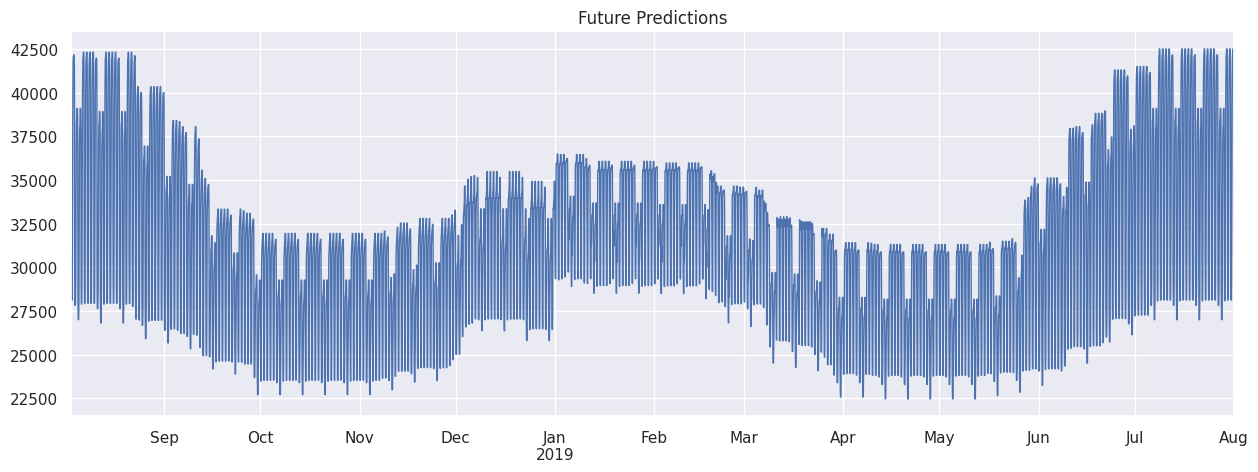

In [92]:
future_with_features["pred"].plot(figsize=(15,5), ms=1, lw=1, title="Future Predictions")

## Saving model for later

In [97]:
reg.save_model("model/model.json")

In [98]:
reg_new = xgb.XGBRegressor()
reg_new.load_model("model/model.json")

<AxesSubplot:title={'center':'Future Predictions'}>

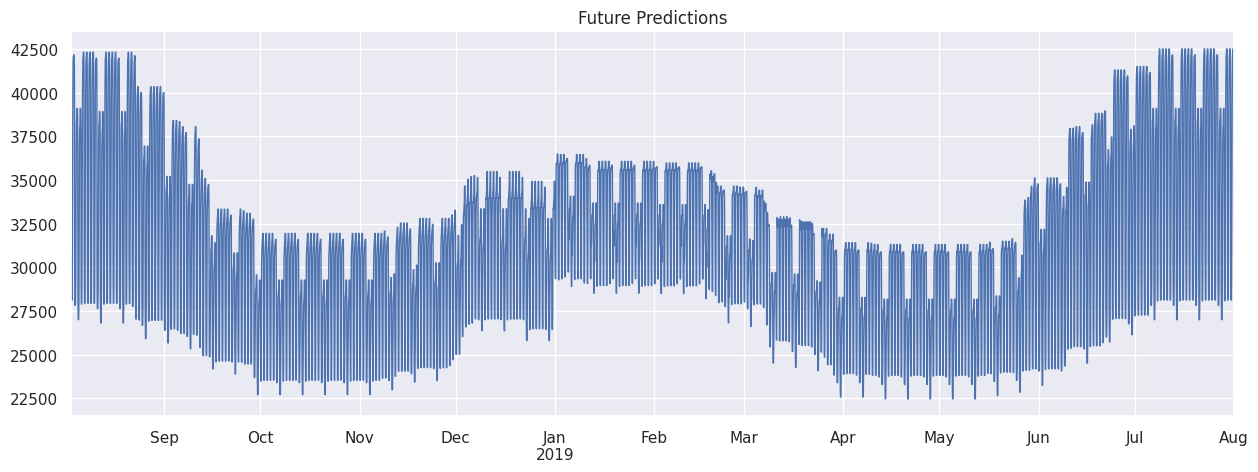

In [99]:
future_with_features["pred"] = reg_new.predict(future_with_features[FEATURES])
future_with_features["pred"].plot(figsize=(15,5), ms=1, lw=1, title="Future Predictions")